In [180]:
from cbds.deeplearning.models.vgg16 import vgg16
#from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.models import Model

# def vgg16_model(trainable=True):
#     base_model = VGG16(False, weights="imagenet")
#     for layer in base_model.layers:
#         layer.trainable = True
    
#     last_conv_layer = base_model.get_layer("block5_conv3")
#     x = GlobalAveragePooling2D()(last_conv_layer.output)
#     x = Dense(512, activation="relu")(x)  
#     x = BatchNormalization(axis=-1)(x)
#     x = Dropout(0.25)(x)
#     predictions = Dense(1, activation="sigmoid")(x)
#     return Model(base_model.input, predictions)

def vgg16_model(trainable=True):
     base_model = vgg16((75,75,3), include_top=False, weights="imagenet")
     for layer in base_model.layers:
         layer.trainable = True
    
     last_conv_layer = base_model.get_layer("block4_conv3") #"block5_conv3") 
     #x = BatchNormalization(axis=-1)() 
     x = GlobalAveragePooling2D()(last_conv_layer.output)
     x = Dense(512, activation="relu")(x) #, kernel_regularizer=regularizers.l2(1e-4))(x) 
     x = Dropout(0.5)(x)
     x = Dense(512, activation="relu")(x)         
     x = Dropout(0.5)(x)
     predictions = Dense(1, activation="sigmoid")(x)
     return Model(base_model.input, predictions)

model = vgg16_model(False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
batch_normalization_55 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
batch_normalization_56 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
__________

In [2]:
from ProjectPaths import ProjectPaths
import numpy as np
import os
import cv2

In [3]:
heerlen_images_filename = os.path.join(ProjectPaths.instance().image_dir, "deepsolaris_heerlen.npy")
heerlen_labels_filename = os.path.join(ProjectPaths.instance().image_dir, "deepsolaris_heerlen_labels.npy")

In [4]:
heerlen_images = np.load(heerlen_images_filename)
heerlen_labels = np.load(heerlen_labels_filename)
heerlen_labels.shape

(15540,)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

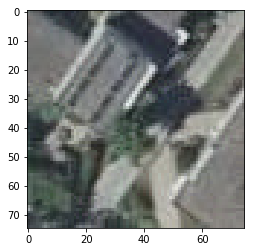

In [6]:
plt.imshow(heerlen_images[0][:,:,::-1])

In [7]:
heerlen_images_normalized = heerlen_images / 255
heerlen_images_normalized.shape, heerlen_images_normalized.min(), heerlen_images_normalized.max()

((15540, 75, 75, 3), 0.0, 1.0)

In [8]:
from sklearn.model_selection import train_test_split

train_images, test_validation_images, train_labels, test_validation_labels = train_test_split(heerlen_images_normalized, heerlen_labels, test_size=0.20)
test_images, validation_images, test_labels, validation_labels = train_test_split(test_validation_images, test_validation_labels, test_size=0.50)

In [56]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range = 0.1,
    zoom_range = 0.3,
    shear_range = 0.15,                                
    #brightness_range = [0.9, 1.1],
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator()

In [197]:
from keras.optimizers import SGD

batch_size = 64
epochs = 100
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

In [11]:
test_images.shape

(1554, 75, 75, 3)

In [12]:
train_generator = data_generator.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size, shuffle=False)

In [198]:
from PerformanceMetrics import PerformanceMetrics

#model.compile(optimizer="adadelta", loss='binary_crossentropy',
model.compile(optimizer=sgd, loss='binary_crossentropy',
                  metrics=['accuracy', PerformanceMetrics.precision,
                           PerformanceMetrics.recall, PerformanceMetrics.fmeasure])

In [14]:
heerlen_labels[heerlen_labels == 0].size, heerlen_labels[heerlen_labels == 1].size

(11410, 4130)

In [15]:
heerlen_labels[heerlen_labels == 0].size / heerlen_labels[heerlen_labels == 1].size

2.76271186440678

In [16]:
class_weights = {
    0: 1.,
    1: heerlen_labels[heerlen_labels == 0].size / heerlen_labels[heerlen_labels == 1].size 
}

In [199]:
-

Epoch 1/100
194/194 [==============================] - 18s 94ms/step - loss: 0.3521 - acc: 0.9071 - precision: 0.7895 - recall: 0.8954 - fmeasure: 0.8331 - val_loss: 0.2306 - val_acc: 0.9134 - val_precision: 0.8211 - val_recall: 0.8360 - val_fmeasure: 0.8251

Epoch 00001: val_acc improved from -inf to 0.91341, saving model to /media/tim/Data/Work/CBS/DeepSolaris/Models/vgg16_heerlen_batch_norm_15-03-2019_18:07:31_2019-03-15_64_100/vgg16_heerlen_batch_norm_15-03-2019_18:07:31__01_0.91.hdf5
Epoch 2/100
194/194 [==============================] - 18s 91ms/step - loss: 0.3760 - acc: 0.9011 - precision: 0.7812 - recall: 0.8809 - fmeasure: 0.8206 - val_loss: 0.2405 - val_acc: 0.8993 - val_precision: 0.7528 - val_recall: 0.8970 - val_fmeasure: 0.8165

Epoch 00002: val_acc did not improve from 0.91341
Epoch 3/100
194/194 [==============================] - 18s 92ms/step - loss: 0.3638 - acc: 0.9033 - precision: 0.7841 - recall: 0.8871 - fmeasure: 0.8271 - val_loss: 0.3434 - val_acc: 0.8450 - val

Text(0.5, 0, 'Epochs')

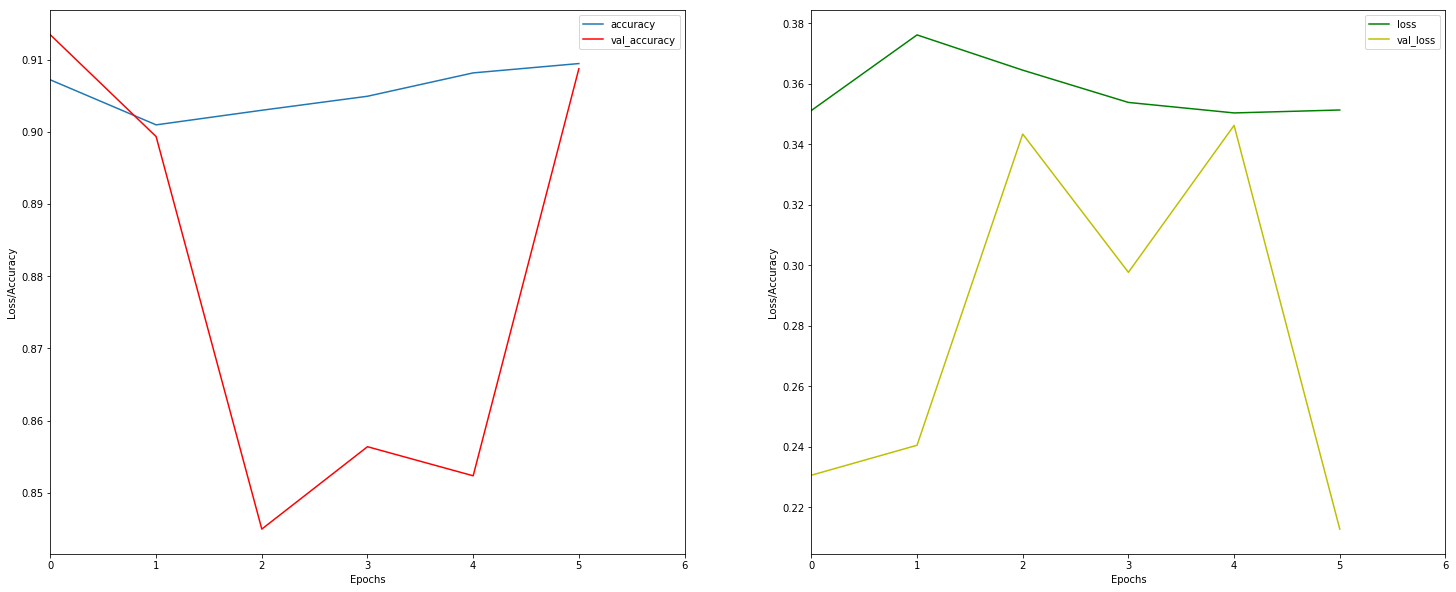

In [200]:
epochs_ran = len(H.history["loss"])

_, ax = plt.subplots(1,2, figsize=(25, 10))
ax[0].plot(np.arange(0, epochs_ran), H.history["acc"], label="accuracy")
ax[0].plot(np.arange(0, epochs_ran), H.history["val_acc"], label="val_accuracy", color="r")
ax[0].set_xlim([0, epochs_ran])
ax[1].plot(np.arange(0, epochs_ran), H.history["loss"], label="loss", color="g")
ax[1].plot(np.arange(0, epochs_ran), H.history["val_loss"], label="val_loss", color="y")
ax[1].set_xlim([0, epochs_ran])
ax[0].legend()
ax[1].legend()

ax[0].set_ylabel("Loss/Accuracy")
ax[0].set_xlabel("Epochs")

ax[1].set_ylabel("Loss/Accuracy")
ax[1].set_xlabel("Epochs")


In [25]:
import pandas as pd

train_eval = model.evaluate(train_images, train_labels, batch_size)
test_eval = model.evaluate(test_images, test_labels, batch_size)
validation_eval = model.evaluate(validation_images, validation_labels, batch_size)

np_model_evaluations = np.array([train_eval, test_eval, validation_eval])

evaluations = pd.DataFrame(np_model_evaluations, columns=model.metrics_names)
print(evaluations.head())

1554/1554 [==============================] - 1s 434us/step
       loss       acc  precision    recall  fmeasure
0  0.405263  0.866715   0.670435  0.976861  0.791394
1  0.463332  0.839125   0.616844  0.958405  0.747947
2  0.463206  0.840412   0.635416  0.950209  0.757661


In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve

def find_optimal_cutoff(target, predicted):
   """ Find the optimal probability cutoff point for a classification model related to event rate
   Parameters
   ----------
   target : Matrix with dependent or target data, where rows are observations

   predicted : Matrix with predicted data, where rows are observations

   Returns
   -------
   list type, with optimal cutoff value

   """
   fpr, tpr, threshold = roc_curve(target, predicted)
   i = np.arange(len(tpr))
   roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
   roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

   return list(roc_t['threshold'])

In [27]:
test_predictions = model.predict(test_images, batch_size)

In [28]:
cut_off = find_optimal_cutoff(test_labels, test_predictions)
cut_off

/home/tim/.virtualenvs/DeepSolaris/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[0.7274746894836426]

In [29]:
from sklearn.metrics import confusion_matrix

predicted_labels = test_predictions > cut_off
confusion_matrix(test_labels, predicted_labels)

array([[1039,  122],
       [  39,  354]])

In [30]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      1161
           1       0.74      0.90      0.81       393

   micro avg       0.90      0.90      0.90      1554
   macro avg       0.85      0.90      0.87      1554
weighted avg       0.91      0.90      0.90      1554



In [31]:
validation_predictions = model.predict(validation_images, batch_size)

In [32]:
from sklearn.metrics import confusion_matrix

predicted_validation_labels = validation_predictions > cut_off
confusion_matrix(validation_labels, predicted_validation_labels)

array([[1026,  112],
       [  33,  383]])

In [33]:
print(classification_report(validation_labels, predicted_validation_labels))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1138
           1       0.77      0.92      0.84       416

   micro avg       0.91      0.91      0.91      1554
   macro avg       0.87      0.91      0.89      1554
weighted avg       0.92      0.91      0.91      1554



Use trained model to classify rest of Heerlen data

In [34]:
extra_image_path_2018 = os.path.join(ProjectPaths.instance().image_dir, "Tiles/Heerlen75x75/2018")
extra_image_path_2018

'/media/tim/Data/Work/CBS/DeepSolaris/Images/Tiles/Heerlen75x75/2018'

In [35]:
from DirectoryFilter import DirectoryFilter
directoryFilter = DirectoryFilter(root_path=extra_image_path_2018)
rgb_images_2018 = directoryFilter.rgb.images.paths
rgb_images_2018[:3]

['/media/tim/Data/Work/CBS/DeepSolaris/Images/Tiles/Heerlen75x75/2018/00001900-3f87-4a57-8e1a-8fbdf3127213_rgb_2018.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Tiles/Heerlen75x75/2018/00023872-f873-4889-9b80-113677b9e86a_rgb_2018.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Tiles/Heerlen75x75/2018/00024a4c-54fe-4d74-838b-20b8ee7f4777_rgb_2018.tiff']

In [36]:
len(rgb_images_2018)

87517

In [37]:
import cv2

cv_images = [cv2.imread(filename) for filename in rgb_images_2018]
images_2018 = np.array(cv_images)
images_2018 = images_2018 / 255

In [38]:
images_2018.shape

(87517, 75, 75, 3)

In [39]:
image_predictions = model.predict(images_2018, batch_size)

In [40]:
predicted_image_labels = image_predictions > cut_off

In [41]:
predicted_image_labels[predicted_image_labels == 0].size, predicted_image_labels[predicted_image_labels == 1].size

(74761, 12756)

In [42]:
negatives_2018 = []
positives_2018 = []
for label, image in zip(predicted_image_labels, images_2018):
    if label == 1:
        positives_2018.append(image)
        continue
    negatives_2018.append(image)
   
len(negatives_2018), len(positives_2018)

(74761, 12756)

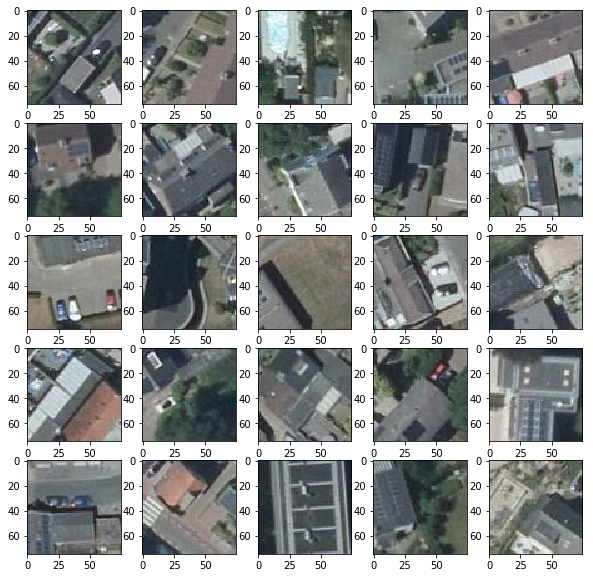

In [43]:
_, ax = plt.subplots(5,5,figsize=(10,10))

i = 0
for r in range(5):
    for c in range(5):
        ax[r, c].imshow(positives_2018[-1 - i][:,:,::-1])
        i += 1

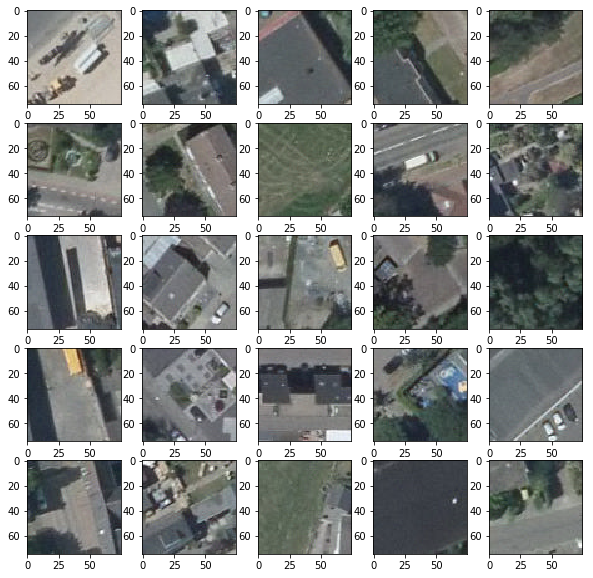

In [44]:
_, ax = plt.subplots(5,5,figsize=(10,10))

i = 0
for r in range(5):
    for c in range(5):
        ax[r, c].imshow(negatives_2018[i][:,:,::-1])
        i += 1

In [45]:
predicted_validation_labels = predicted_validation_labels.reshape(predicted_validation_labels.shape[0])
diff_predictions = predicted_validation_labels & (validation_labels == 1)
predicted_validation_labels.shape, validation_labels.shape, diff_predictions.shape

((1554,), (1554,), (1554,))

In [46]:
(validation_labels == 1),predicted_validation_labels

(array([False, False,  True, ..., False, False, False]),
 array([ True, False,  True, ..., False, False, False]))

In [47]:
diff_predictions = np.equal(predicted_validation_labels, (validation_labels == 1))
np.sum(diff_predictions)

1409

In [48]:
wrongly_classified = validation_images[np.where(diff_predictions == 0)]
wrongly_classified.shape

(145, 75, 75, 3)

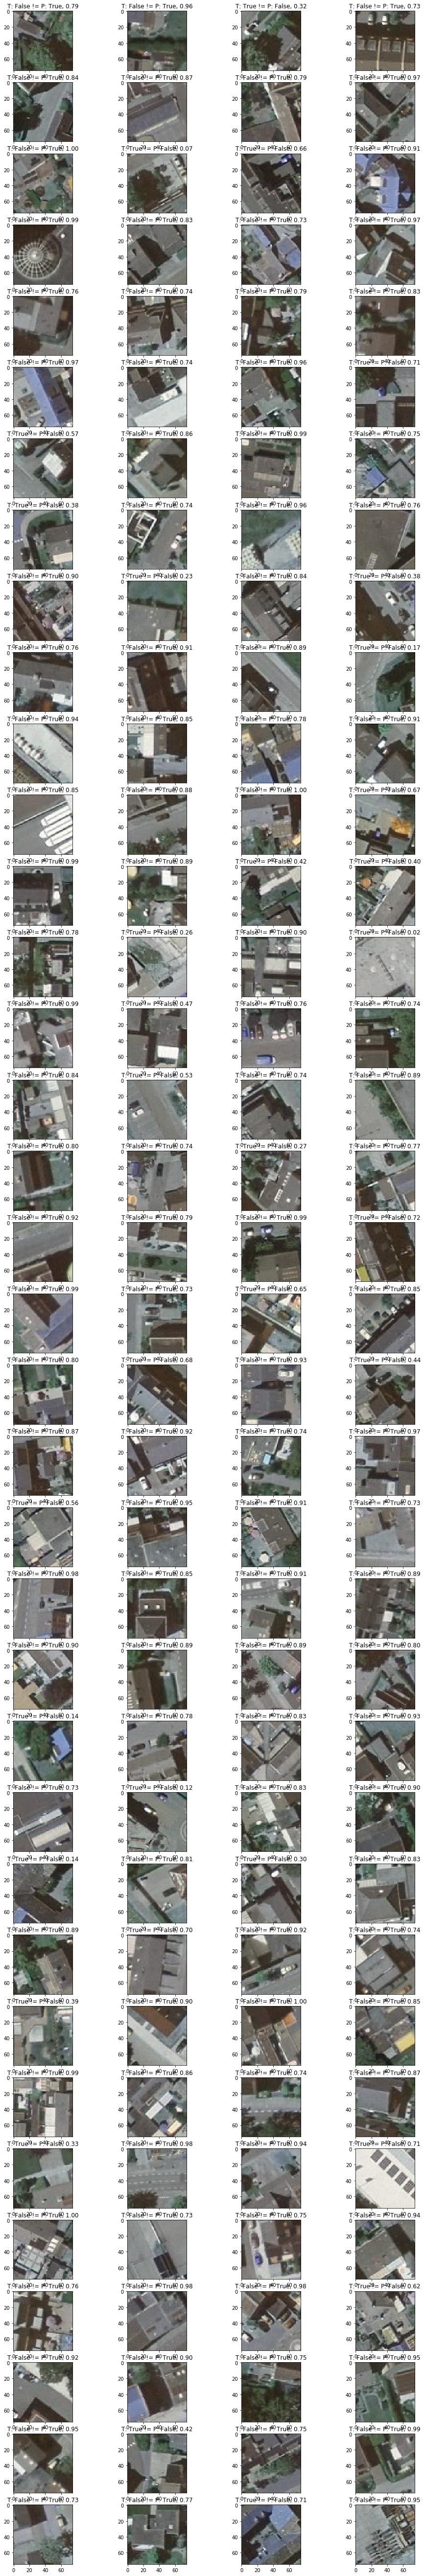

In [49]:
_, ax = plt.subplots(36, 4, figsize=(16, 96))

indexes = np.where(diff_predictions == 0)
i = 0
for r in range(36):
    for c in range(4):
        ax[r, c].imshow(wrongly_classified[i])
        index = indexes[0][i]
        ax[r, c].set_title("T: {} != P: {}, {:.2f}".format(validation_labels[index] == 1, predicted_validation_labels[index], validation_predictions[index][0]))
        i += 1
    